In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import time
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import PIL 
from tqdm import tqdm
import matplotlib.pyplot as plt
# tsne and pca
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from IPython.display import clear_output
import untils

torch.Size([1, 1, 28, 28]) tensor([3])
tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
    

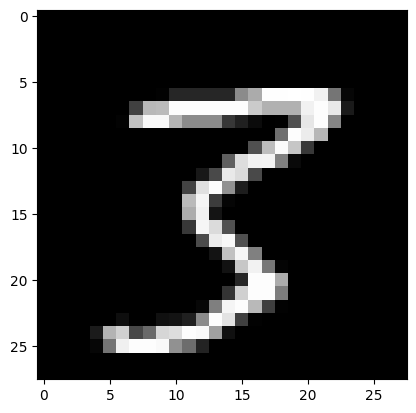

In [2]:
download = False
dataset_class = datasets.MNIST
mnist_transform = [transforms.ToTensor()]
# mnist_transform.append(transforms.Normalize((0.1307,), (0.3081,)))
dataset_transform = transforms.Compose(mnist_transform)
mnist_train = dataset_class('data/MNIST', train=True, download=download, transform=dataset_transform)
mnist_test = dataset_class('data/MNIST', train=False, download=download, transform=dataset_transform)

# mnist_train.data.to('cuda')
# mnist_train.targets.to('cuda')
# # mnist_test.data.to('cuda')
# mnist_test.data.to('cuda')
# mnist_test.targets.to('cuda')
# mnist_test.labels
# create a dataloader with
#  batch size 1
mnist_train_loader = DataLoader(mnist_train, batch_size=1, shuffle=True)
mnist_test_loader = DataLoader(mnist_test, batch_size=1, shuffle=True)

# test the dataloader
for i, (data, target) in enumerate(mnist_train_loader):
    print(data.shape, target)
    print(data)
    # display the first image
    plt.imshow(data[0, 0].numpy(), cmap='gray')
    plt.show()
    break

seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# randonly shuffle the training data
mnist_train_loader = DataLoader(mnist_train, batch_size=8, shuffle=True)

In [149]:
class CobwebNNTreeLayer(nn.Module):
    '''
    TODO: try more complex approximation of p_c and p_x_given_c
            maybe add non-linearity and more layers to the approximation
    '''
    def __init__(self, n_hidden, out_features, branch_factor=2):
        super(CobwebNNTreeLayer, self).__init__()
        self.n_hidden = n_hidden
        self.out_features = out_features
        self.branch_factor = branch_factor
        
        self.p_c = nn.Parameter(nn.init.normal_(torch.empty(out_features//branch_factor, branch_factor))) # might do log softmax?
        self.p_x_given_c = nn.Linear(n_hidden, out_features, bias=True)
        # self.p_c = nn.Sequential(
        #     nn.Linear(out_features//branch_factor, out_features),
        #     # nn.ReLU(),
        #     nn.Tanh(),
        #     nn.Linear(out_features, out_features, bias=True),
        #     # nn.LogSoftmax(dim=1)
        # )

        # self.p_x_given_c = nn.Sequential(
        #     nn.Linear(n_hidden, out_features),
        #     # nn.ReLU(),
        #     nn.Tanh(),
        #     nn.Linear(out_features, out_features, bias=True),
        #     # nn.LogSoftmax(dim=1)
        # )

        self.activation = nn.ReLU()
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x, z):
        # z_expanded = z.unsqueeze(2).expand(-1, -1, self.branch_factor).reshape(z.size(0), -1)
        z = z.unsqueeze(2).expand(-1, -1, self.branch_factor).reshape(z.size(0), -1)

        p_c = z + self.p_c.flatten()
        # p_c = z_expanded + self.p_c(z)
        p_x_given_c = self.p_x_given_c(x)

        z = p_x_given_c + p_c
        z = self.logsoftmax(z)
        return x, z
    
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # nn.Conv2d(64, 64, 3),
            # nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=2),
        )

    def forward(self, x):
        x = self.encoder(x)
        return x.view(x.size(0), -1)
    


class CobwebNN(nn.Module):
    def __init__(self, n_layers=3, n_hidden=784, branch_factor=2):
        super(CobwebNN, self).__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.branch_factor = branch_factor

        self.layers = nn.ModuleList(
            [CobwebNNTreeLayer(n_hidden, branch_factor ** i, branch_factor) for i in range(1, n_layers + 1)]
        )

        self.CNN = SimpleCNN()

    def layer_KL_loss(self, x, z):
        cluster_mass = torch.logsumexp(z, dim=0) # shape: (out_features,)
        p_clusters = torch.softmax(cluster_mass, dim=0)

        p_of_batch_given_clusters = torch.exp(z - cluster_mass.unsqueeze(0).expand(z.shape[0], -1)).unsqueeze(2).expand(z.shape[0], z.shape[1], x.shape[1])
        # shape: (batch_size, out_features, n_hidden)
        cluster_centorids = (x.unsqueeze(1).expand(z.shape[0], z.shape[1], x.shape[1]) * p_of_batch_given_clusters).sum(dim=0)
        # print(f"p(b|c): {p_of_batch_given_clusters}", p_of_batch_given_clusters.shape)
        # shape: (out_features, n_hidden)

        # reconstruct the parent centroid
        # by defning the parent mass is the sum of the child mass
        z_parent = torch.logsumexp(z.reshape(z.shape[0], -1, self.branch_factor), dim=2)
        # print(f"z_parent: {z_parent}")
        parent_cluster_mass = torch.logsumexp(z_parent, dim=0)
        # print(f"parent_cluster_mass: {parent_cluster_mass}")
        p_of_batch_given_parent_clusters = torch.exp(z_parent - parent_cluster_mass.unsqueeze(0).expand(z_parent.shape[0], -1)).unsqueeze(2).expand(z_parent.shape[0], z_parent.shape[1], x.shape[1])
        parent_cluster_centorids = (x.unsqueeze(1).expand(z_parent.shape[0], z_parent.shape[1], x.shape[1]) * p_of_batch_given_parent_clusters).sum(dim=0)
        # print(f"p(b|p): {p_of_batch_given_parent_clusters}", p_of_batch_given_parent_clusters.shape)

        # calculate the KL divergence
        parent_cluster_centorids = parent_cluster_centorids.unsqueeze(1).expand(parent_cluster_centorids.shape[0], self.branch_factor, parent_cluster_centorids.shape[1]).reshape(-1, parent_cluster_centorids.shape[1])
        KL_loss = torch.pow(parent_cluster_centorids - cluster_centorids, 2).sum(dim=1) * p_clusters
        KL_loss = KL_loss.sum()

        return KL_loss

    def forward(self, x):
        layer_outputs = []
        x = x.view(-1, self.n_hidden)
        # print(x.shape)
        # x = self.CNN(x)
        # print(f"range of x: {x.min()}, {x.max()}")
        z = torch.zeros((x.size(0), 1), device=x.device)

        loss = 0
        KL_loss = 0
        for layer in self.layers:
            # print(f"parent z: {z}")
            # convert to probs
            # print(f"parent activatoin (probabilities): {torch.exp(z)}\n")
            x, z = layer(x, z)
            # print(f"child z: {z}")
            # print(f"child activatoin (probabilities): {torch.exp(z)}\n")
            # print(f"range of z: {z.min()}, {z.max()}")
            layer_outputs.append(z)

            KL_loss -= self.layer_KL_loss(x, z)

        loss = KL_loss

        return untils.ModelOutput(loss=loss, 
                                  layer_outputs=layer_outputs,
                                  x=x,
                                  )


In [ ]:
mnist_train_9_7 = untils.filter_by_label(mnist_train, [9, 7])
mnist_test_9_7 = untils.filter_by_label(mnist_test, [9, 7])

100%|██████████| 10000/10000 [00:00<00:00, 10896.93it/s]


Epoch 3/3: 100%|██████████| 48/48 [00:00<00:00, 235.92it/s, loss=-0.428]


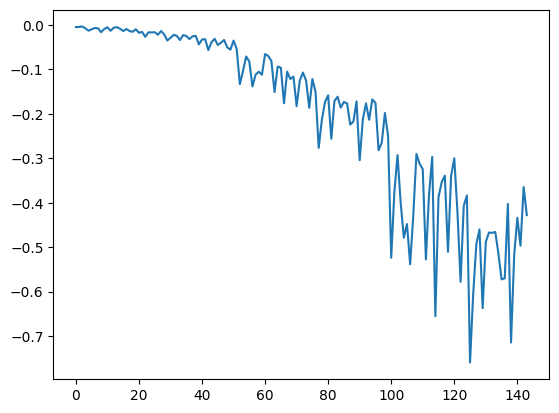

In [154]:
n_layers = 1
model = CobwebNN(n_layers=n_layers, branch_factor=2, n_hidden=784).to('cuda')
optimizer = optim.Adam(model.parameters(), lr=1e-4)




untils.train_model(model, mnist_train_9_7, optimizer, epochs=3, batch_size=256, show_loss=True, device='cuda', verbose=False, early_break=False)

 25%|██▌       | 1/4 [00:00<00:00, 119.59it/s]


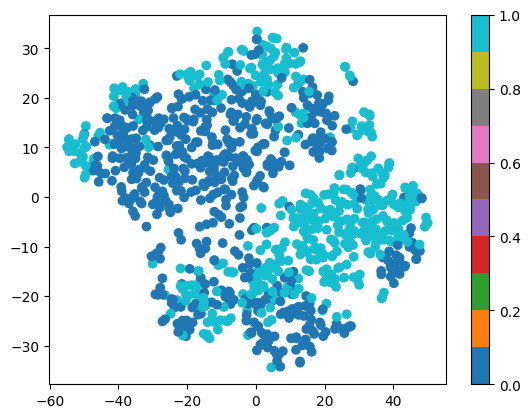

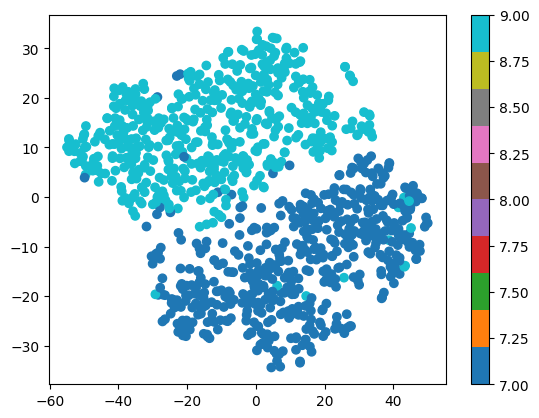

In [155]:
untils.visualize_decision_boundary(model, mnist_test_9_7, layer=0, n_hidden=784)

  5%|▌         | 1/20 [00:00<00:01,  9.94it/s]


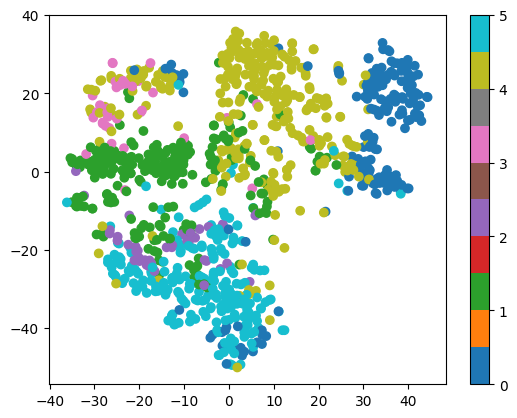

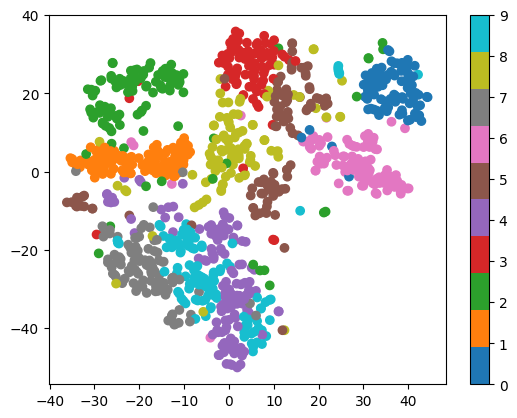

In [7]:
untils.visualize_decision_boundary(model, mnist_test, layer=2, n_hidden=784)